## Init

In [1]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path+'/src')
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\new-peak-project\src


In [2]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

G:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [3]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

## Notebook Parameters

In [ ]:
import os 

## Generation of ground truth model 

model_name = 'v4_drug_model' # name of the model
random_seeds = list(range(1, 11)) # list of random seeds for model generation
# p_overall_seed = 46 # different seed for parameter generation
no_observable_species = 5
no_feedback_regulations = 2
specie_value_range = (1000, 5000)
param_range = (0.8, 1.2)
param_multiplier_range = (0.99, 1.01)


## Simulation parameters 

simulation_time = 1000 
simulation_step = 100

## Feature data generation 

feature_generation_method = 'lhs'
feature_generation_extra_params = {'min': 0.1, 'max': 10}
feature_generation_size = 1000 
feature_generation_seed = 50 # if -1 then 'o_random_seed' is used

## Simulation difference based on seeds

In [14]:
# create a drug enabled model 
from models.Utils import *
from models.DrugModelSpecification import DrugModelSpecification, Drug

results = []
for o_random_seed in random_seeds:

    model_drug_spec = DrugModelSpecification()
    model_drug_spec.generate_specifications(o_random_seed, no_observable_species, no_feedback_regulations, verbose=0)
    drug_0 = Drug('D0', 500, 500)
    rng = np.random.default_rng(o_random_seed)
    # add random 'up' and 'down' regulations to the drug
    regulation_dir = []
    for i, s in enumerate(model_drug_spec.A_species):
        reg_type = str(rng.choice(['up', 'down']))
        regulation_dir.append(reg_type)
        drug_0.add_regulation(s, reg_type)
    model_drug_spec.add_drug(drug_0)
    # print(model_drug_spec)
    # print(f'Feedback: {model_drug_spec.get_feedback_regulations()}')
    p_random_seeds = []
    feature_size = 1000 
    rng = np.random.default_rng(o_random_seed)
    # generate `feature_size` random seeds for different parameter sets using numpy, ensure that the seeds are unique
    p_random_seeds = rng.choice(range(1000000), feature_size, replace=False).tolist()
    G0_d = model_drug_spec.generate_network('drug_model_524', 
                                            specie_value_range, 
                                            param_range, 
                                            param_multiplier_range,  
                                            verbose=0,
                                            random_seed=p_random_seeds[0])
    base_parameters = G0_d.get_parameters()
    base_initial_conditions = G0_d.get_state_variables()

    # print(G0_d.get_antimony_model())
    parameter_sets = []
    for p in p_random_seeds: 
        model_build = model_drug_spec.generate_network(f'param_seed_{p}', 
                                                specie_value_range, param_range, param_multiplier_range, random_seed=p, verbose=0)
        parameter_sets.append(model_build.get_parameters())
    # test simulation 

    from models.Solver.RoadrunnerSolver import RoadrunnerSolver

    solver = RoadrunnerSolver()
    solver.compile(G0_d.get_sbml_model())

    result = solver.simulate(0, 1000, 100)
    results.append(result)
    print(f'Simulation result for seed {o_random_seed} complete')

Simulation result for seed 1:           time          A0p           A0         Cp        A1p           A1  \
0      0.00000     0.000000  2593.000000   0.000000   0.000000  3606.000000   
1     10.10101     8.978394  2584.021606   7.340168   6.402214  3599.597786   
2     20.20202    17.878896  2575.121104  13.593820   9.147960  3596.852040   
3     30.30303    25.586931  2567.413069  16.901093  10.380175  3595.619825   
4     40.40404    31.288641  2561.711359  18.162547  10.943666  3595.056334   
..         ...          ...          ...        ...        ...          ...   
95   959.59596  2573.627832    19.372168   9.233275   4.390544  3601.609456   
96   969.69697  2573.627832    19.372168   9.233275   4.390544  3601.609456   
97   979.79798  2573.627832    19.372168   9.233276   4.390544  3601.609456   
98   989.89899  2573.627832    19.372168   9.233276   4.390544  3601.609456   
99  1000.00000  2573.627832    19.372168   9.233276   4.390544  3601.609456   

          A2p        

## Plotting

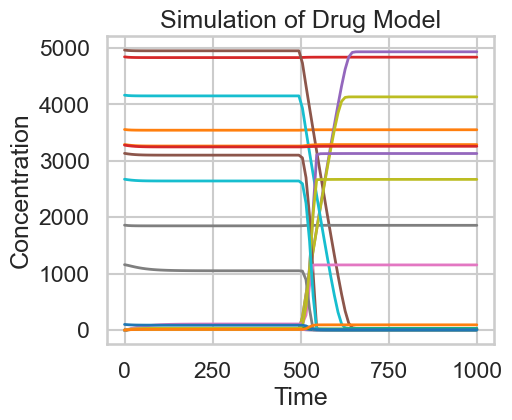

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
sns.set_style("whitegrid")
plt.figure(figsize=(5, 4))

for i, s in enumerate(G0_d.get_state_variables()):
    plt.plot(result['time'], result[s], label=s, linewidth=2)
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Simulation of Drug Model')
plt.show()

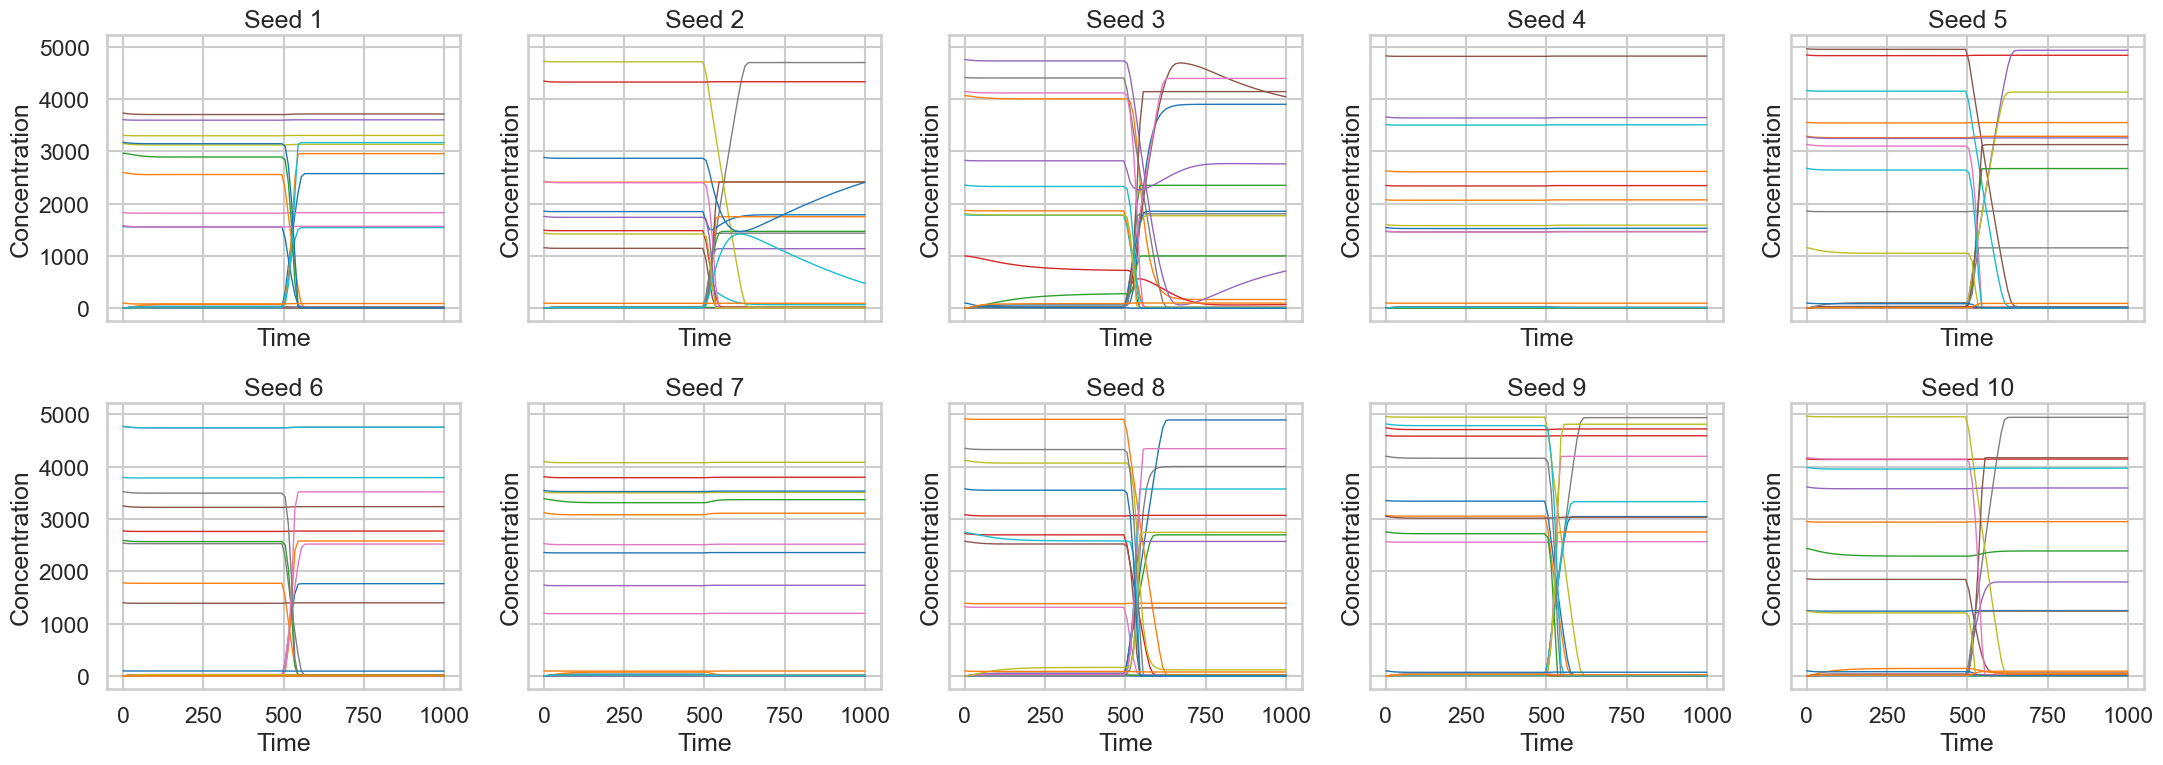

In [17]:
fig, axes = plt.subplots(2, 5, figsize=(22, 8), sharex=True, sharey=True)
axes = axes.flatten()

for idx, (res, ax) in enumerate(zip(results, axes)):
    for s in res.columns:
        if s != 'time':
            ax.plot(res['time'], res[s], label=s, linewidth=1)
    ax.set_title(f'Seed {idx+1}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Concentration')
    # ax.legend(fontsize='small', loc='upper right', ncol=2, frameon=False)

plt.tight_layout()
plt.show()

## More Simulation specifics to a seed

In [ ]:
from models.SyntheticGen import generate_feature_data, generate_target_data, generate_feature_data_v2, generate_target_data_diff_build

feature_data = generate_feature_data_v2(model_drug_spec, base_initial_conditions, feature_generation_method, feature_generation_extra_params, 1000, feature_generation_seed)
target_data, _ = generate_target_data_diff_build(model_drug_spec, solver, 
                                                 feature_data, parameter_sets, 
                                                 {'start': 0, 'end': 1000, 'points': 100}, 
                                                 n_cores=1, verbose=True)

Simulating perturbations: 100%|██████████| 1000/1000 [00:04<00:00, 206.72it/s]


In [19]:
from models.SyntheticGen import generate_model_timecourse_data_diff_build
time_course_data = generate_model_timecourse_data_diff_build(model_drug_spec, solver,
                                                            feature_data, parameter_sets, 
                                                            {'start': 0, 'end': 1000, 'points': 100}, 
                                                            n_cores=1, verbose=True)

Simulating perturbations: 100%|██████████| 1000/1000 [00:05<00:00, 166.85it/s]


In [21]:
time_course_data

,A0,A0p,A1,A1p,A2,A2p,A3,A3p,A4,A4p,...,B1,B1p,B2,B2p,B3,B3p,B4,B4p,C,Cp
0,"[9.982304515350323, 9.471954639692889, 9.26796...","[0.0, 0.510349875657434, 0.7143384374812035, 0...","[0.4382466735876226, 0.41410600397382535, 0.40...","[0.0, 0.024140669613797246, 0.0336107907751461...","[6.371175745844176, 6.040877053286876, 5.91369...","[0.0, 0.33029869255729716, 0.4574774763489313,...","[9.010262853948213, 8.546203902241466, 8.36104...","[0.0, 0.46405895170674616, 0.6492224083271013,...","[4.780355347776668, 4.525979876953602, 4.42529...","[0.0, 0.25437547082307, 0.35506527944692273, 0...",...,"[4.980056241896318, 4.715003508470793, 4.60963...","[0.0, 0.2650527334255271, 0.3704186451260409, ...","[2.1734997816941464, 2.0525940745438476, 2.002...","[0.0, 0.12090570715029873, 0.17095394717461718...","[9.867316660917776, 9.34535986627787, 9.121584...","[0.0, 0.5219567946399131, 0.7457325574323329, ...","[6.8788669386058166, 6.512087251966956, 6.3604...","[0.0, 0.36677968663886107, 0.5184441120669232,...","[100.0, 96.74686836479637, 95.11763122418037, ...","[0.0, 3.2531316352036157, 4.882368775819595, 5..."
1,"[5.73323184522851, 5.389357124985702, 5.281627...","[0.0, 0.3438747202428099, 0.45160443620291596,...","[6.362766555090388, 5.983067338185284, 5.86391...","[0.0, 0.3796992169051025, 0.4988509676968766, ...","[6.472348283707556, 6.090713436367542, 5.97407...","[0.0, 0.381634847340014, 0.49827227943584346, ...","[2.5737609457949793, 2.415343790902092, 2.3661...","[0.0, 0.15841715489288738, 0.20761431270399563...","[5.266696567772818, 4.94960751582339, 4.850393...","[0.0, 0.31708905194943154, 0.4163029194491485,...",...,"[2.7078684986141734, 2.537670407861752, 2.4821...","[0.0, 0.1701980907524231, 0.22575442781183808,...","[3.7442682833050687, 3.5108864702475153, 3.434...","[0.0, 0.2333818130575528, 0.30975368547769383,...","[9.623650706207354, 9.05883195573879, 8.876290...","[0.0, 0.564818750468556, 0.7473602047439586, 0...","[4.608462983112409, 4.32431051551235, 4.231792...","[0.0, 0.28415246760005813, 0.3766705581505531,...","[100.0, 96.42188664466488, 94.9949282982113, 9...","[0.0, 3.578113355335142, 5.005071701788714, 5...."
2,"[4.065739783125794, 3.818739248790843, 3.74285...","[0.0, 0.2470005343349503, 0.322880532582951, 0...","[2.5713000642454884, 2.4126516079259663, 2.364...","[0.0, 0.15864845631952293, 0.2071269760191978,...","[0.18210555990740018, 0.17086749361593098, 0.1...","[0.0, 0.011238066291469213, 0.0144427746633269...","[5.831492059789114, 5.4835455977206005, 5.3760...","[0.0, 0.34794646206851676, 0.45548311030206173...","[6.889065483718838, 6.482372339784294, 6.35624...","[0.0, 0.4066931439345399, 0.5328227781784466, ...",...,"[6.451358755553173, 6.06511453697496, 5.942833...","[0.0, 0.38624421857821284, 0.5085254605777204,...","[2.2252164407477264, 2.0873286431784894, 2.045...","[0.0, 0.13788779756923544, 0.18003377197874984...","[8.408359713372244, 7.909015901565589, 7.74586...","[0.0, 0.4993438118066572, 0.662498456521614, 0...","[4.758216381362555, 4.464075442912356, 4.36838...","[0.0, 0.29414093845019584, 0.38983638038485363...","[100.0, 96.66815316589856, 95.24564063823526, ...","[0.0, 3.3318468341014613, 4.754359361764757, 5..."
3,"[3.814673877307333, 3.6015798294455874, 3.5230...","[0.0, 0.21309404786174738, 0.2916367909568283,...","[6.75156385654199, 6.383524528138544, 6.246963...","[0.0, 0.368039328403447, 0.50460073464936, 0.5...","[5.192769586244278, 4.916186537510615, 4.82230...","[0.0, 0.2765830487336683, 0.37046837561997525,...","[1.8948031027817716, 1.787217381610389, 1.7477...","[0.0, 0.10758572117138329, 0.14705749500534354...","[8.171632906008975, 7.7313351203650305, 7.5674...","[0.0, 0.4402977856439482, 0.6041736633841133, ...",...,"[9.493348842341264, 8.974603229302502, 8.77032...","[0.0, 0.5187456130387575, 0.723021494831778, 0...","[2.034370444489765, 1.9168127247702857, 1.8719...","[0.0, 0.11755771971947934, 0.16241687625215817...","[7.096634935953625, 6.708054560492093, 6.56140...","[0

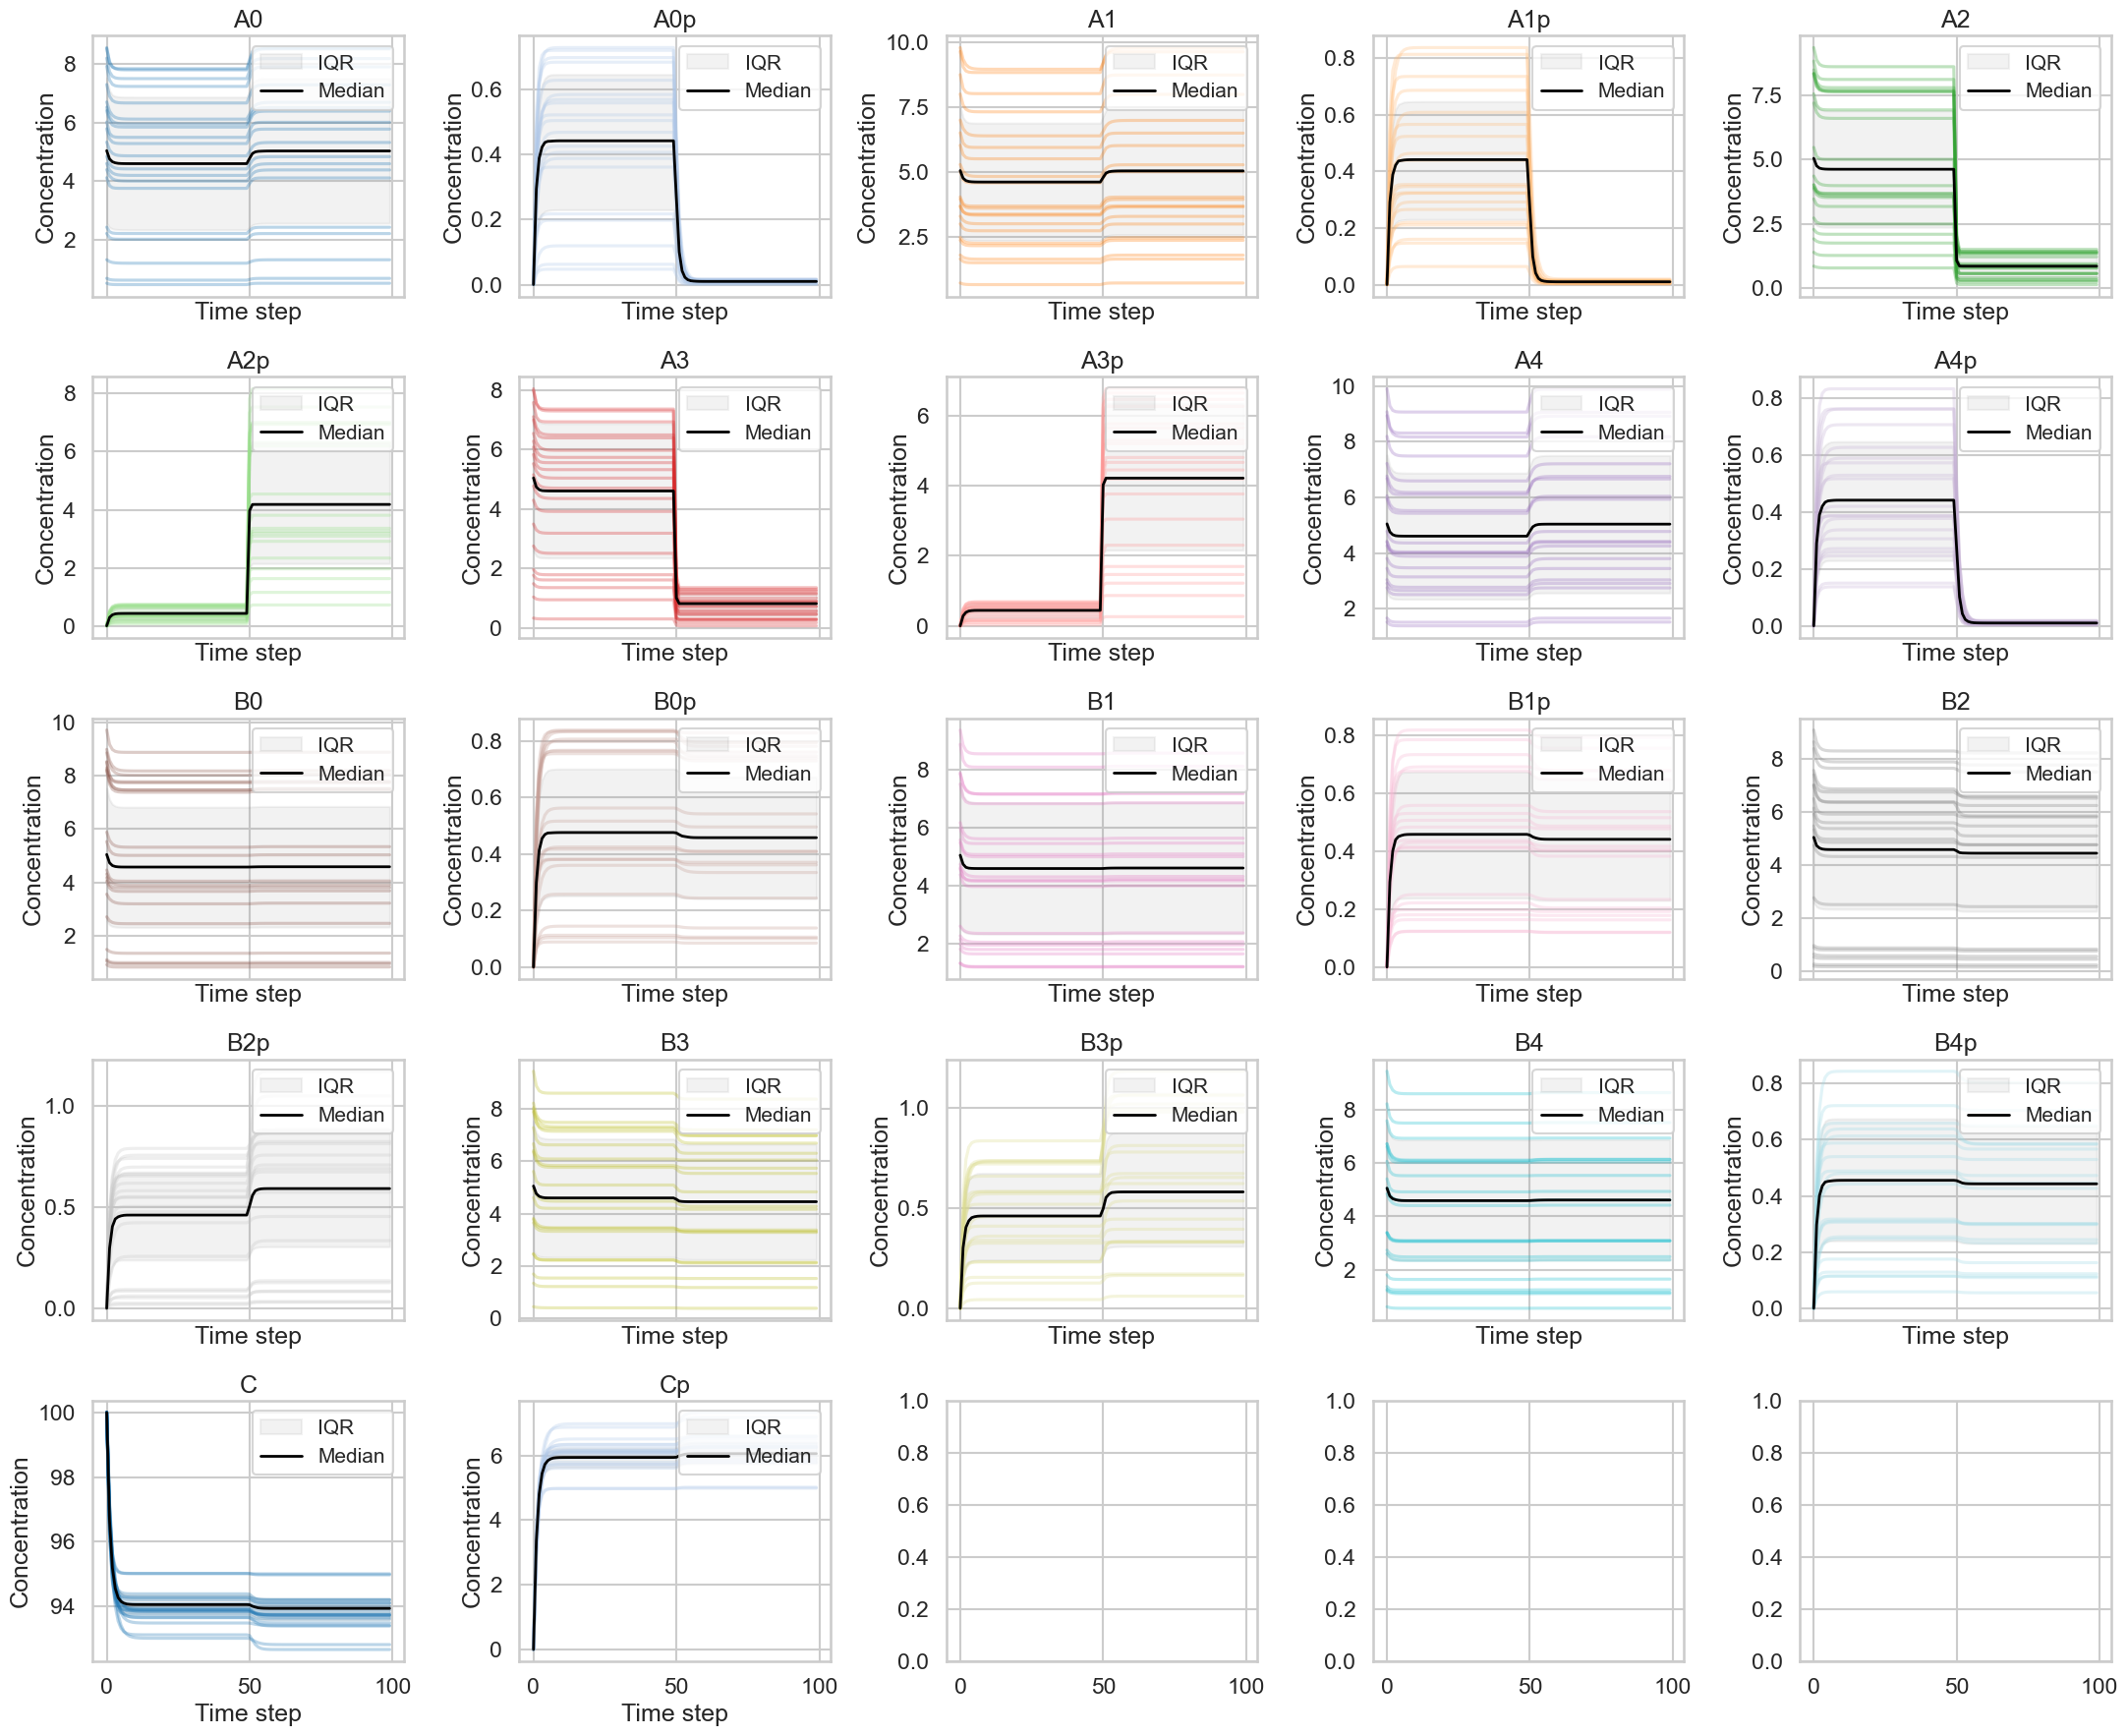

In [33]:
import numpy as np

fig, axes = plt.subplots(5, 5, figsize=(22, 18), sharex=True)
axes = axes.flatten()
species = [col for col in time_course_data.columns if col != 'time']

for idx, specie in enumerate(species):
    ax = axes[idx]
    data_matrix = np.vstack(time_course_data[specie].values)
    sampled_rows = time_course_data[specie].sample(n=20, random_state=42)
    for row in sampled_rows:
        ax.plot(row, color=sns.color_palette("tab20")[idx % 20], alpha=0.3)
    q1 = np.percentile(data_matrix, 25, axis=0)
    q3 = np.percentile(data_matrix, 75, axis=0)
    ax.fill_between(np.arange(len(q1)), q1, q3, color='gray', alpha=0.1, label='IQR')   
    ax.plot(np.median(data_matrix, axis=0), color='black', lw=2, label='Median')  # or use mean
    ax.set_title(specie)
    ax.set_xlabel('Time step')
    ax.set_ylabel('Concentration')
    ax.legend(loc='upper right', fontsize='small')
plt.tight_layout()    
plt.show()